클러스터링은 거리 기반으로는 타겟의 분배를 잘 함.  
여기서 타겟 개수 제한의 경우 문제가 생기는데..  
학습 단계에서 처리할 방법은 쉽게 보이지 않음.  
학습이 완료되고 개수가 지나치게 이상한 경우 추가적인 알고리즘을 사용하여 개수를 적당히 분배할 것.  
여기에서 무게는 일단 배제한다.   


In [2]:
import torch
from torch import multiprocessing
import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append('/home/ksh-server/workspace/ICUFN')
from my_clustering.my_vmas.scenarios.navigation_random import Scenario

In [3]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device

env = Scenario()
world = env.make_world(
        device=device,
        n_agents=4,
        batch_dim=1
    )


In [4]:
def world_reset(env):
    env.reset_world_at()
    agents = env.world.agents
    targets = env.targets
    finished_position = env.finished_pos
    
    return agents, targets, finished_position

In [5]:
def initial_render(agents, targets, finished_position):
    map_size = 2

    # 플롯 생성
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(-map_size, map_size)
    ax.set_ylim(-map_size, map_size)
    ax.set_title("Agent and Target Distribution")

    # 에이전트 플로팅 (파란색 원)
    for i, agent in enumerate(agents):
        x, y = agent.state.pos.squeeze().tolist()
        ax.add_patch(plt.Circle((x, y), agent.shape.radius, color=agent.color, alpha=1, label=f"Agent_{i+1}"))

    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        label = "target" if targets[0] == target else None
        ax.add_patch(plt.Circle((x, y), target.shape.radius, color="black", alpha=1, label=label))
        
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        label = 'finished_position' if finished_position[0] == pos else None
        ax.add_patch(plt.Circle((x, y), targets[0].shape.radius, color='gray', alpha=1, label=label))

    # 범례 및 표시
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

In [6]:
def numpy_pos(agents, targets, finished_position):
    agents_pos = []
    for agent in agents:
        x, y = agent.state.pos.squeeze().tolist()
        agents_pos.append([x, y])
    agents_pos = np.array(agents_pos)
    
    targets_pos = []
    targets_cost = []
    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        targets_pos.append([x, y])
        cost = target.cost.item()
        targets_cost.append(cost)
    targets_pos = np.array(targets_pos)
    targets_cost = np.array(targets_cost)

    finished_pos = []
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        finished_pos.append([x, y])
    finished_pos = np.array(finished_pos)
    
    return agents_pos, targets_pos, targets_cost, finished_pos

In [7]:
agents, targets, finished_position = world_reset(env)

In [8]:
agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)


In [9]:
from sklearn.cluster import KMeans
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

In [10]:
# agents_pos
# targets_pos, targets_cost
# finished_pos

In [11]:
n_clusters = len(agents)

In [12]:
def kmeans_clust(targets_pos):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [13]:
def kmeans_cost_division_clust(targets_pos, targets_cost):
    # 타겟 증식
    for i, cost in enumerate(targets_cost):
        count = cost // 10 - 1
        for _ in range(count):
            targets_pos = np.concatenate((targets_pos, np.expand_dims(targets_pos[i], axis=0)), axis=0)
            
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, targets_pos

In [14]:
def zip_clusters(agents, targets, labels):
    clusters = [[] for _ in range(len(agents))]
    for target, label in zip(targets, labels):
        clusters[label].append(target)
    return clusters

In [15]:
def clusters_render(agents, clusters, centers, func= lambda target : target.state.pos.squeeze().tolist()):
    plt.Figure(figsize=(4, 4))
    for i, cluster in enumerate(clusters):
        for j, target in enumerate(cluster):
            x, y = func(target)
            plt.scatter(x, y, color = agents[i].color, label = f"agent{i+1}" if j == 0 else "")
            
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='*', alpha=0.2, s=200, label='Centers')
    plt.title("Target Position Clustering")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    plt.grid(True)
    plt.axis('equal')
    plt.show()

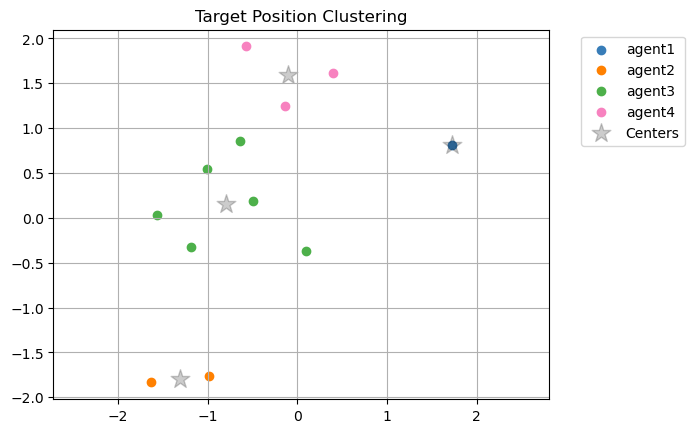

[[<vmas.simulator.core.Landmark object at 0x780744fe3b80>], [<vmas.simulator.core.Landmark object at 0x780744fe3f40>, <vmas.simulator.core.Landmark object at 0x780744fe33d0>], [<vmas.simulator.core.Landmark object at 0x780744fe3190>, <vmas.simulator.core.Landmark object at 0x780744fe2aa0>, <vmas.simulator.core.Landmark object at 0x780744fe1840>, <vmas.simulator.core.Landmark object at 0x780744fe2fe0>, <vmas.simulator.core.Landmark object at 0x780744fe30a0>, <vmas.simulator.core.Landmark object at 0x7807d29ffac0>], [<vmas.simulator.core.Landmark object at 0x780744fe2ef0>, <vmas.simulator.core.Landmark object at 0x7808882679d0>, <vmas.simulator.core.Landmark object at 0x780888265d50>]]


In [16]:
labels, centers = kmeans_clust(targets_pos)
clusters = zip_clusters(agents, targets, labels)
clusters_render(agents, clusters, centers)
print(clusters)

In [ ]:
# 위의 clusters 변수는 open tsp를 통하여 추가적인 경로 설정이 이뤄져야만 함. 
# 어떻게 만들어줄까나...
# 일단은 각 클러스터의 중심점에 대하여 가장 가까운 에이전트를 매칭 시켜줘야한다. 

In [25]:
# clusters, centers, agents, finished_pos
# 이렇게 4개의 변수를 사용할 것

print(centers)
print(agents_pos)

[[ 1.71743464  0.80884624]
 [-1.30668509 -1.80043328]
 [-0.60254484  0.01682615]
 [-0.09802286  1.70644869]]
[[ 0.91261506 -1.98939276]
 [ 0.75657058  0.19262552]
 [-0.04689121 -0.82199025]
 [ 0.95152092  0.42084694]]


In [27]:
for center in centers:
    distances = np.linalg.norm(agents_pos - center, axis=1) 
    closest_idx = np.argmin(distances)
    closest_agent_pos = agents_pos[closest_idx] 
    print("가까운 에이전트: ", closest_idx)
    print("에이전트의 위치: ", agents_pos[closest_idx])

가까운 에이전트:  3
에이전트의 위치:  [0.95152092 0.42084694]
가까운 에이전트:  2
에이전트의 위치:  [-0.04689121 -0.82199025]
가까운 에이전트:  2
에이전트의 위치:  [-0.04689121 -0.82199025]
가까운 에이전트:  3
에이전트의 위치:  [0.95152092 0.42084694]


In [26]:
import numpy as np

# 두 배열 정의
arr1 = np.array([
    [ 1.71743464,  0.80884624],
    [-1.30668509, -1.80043328],
    [-0.60254484,  0.01682615],
    [-0.09802286,  1.70644869]
])

arr2 = np.array([
    [ 0.91261506, -1.98939276],
    [ 0.75657058,  0.19262552],
    [-0.04689121, -0.82199025],
    [ 0.95152092,  0.42084694]
])

# 1번 배열의 첫 번째 원소
target = arr1[0]

# 거리 계산 (유클리드 거리)
distances = np.linalg.norm(arr2 - target, axis=1)

# 가장 가까운 인덱스 및 값
closest_idx = np.argmin(distances)
closest_point = arr2[closest_idx]

print("가장 가까운 점:", closest_point)
print("거리:", distances[closest_idx])


가장 가까운 점: [0.95152092 0.42084694]
거리: 0.8585844648517282


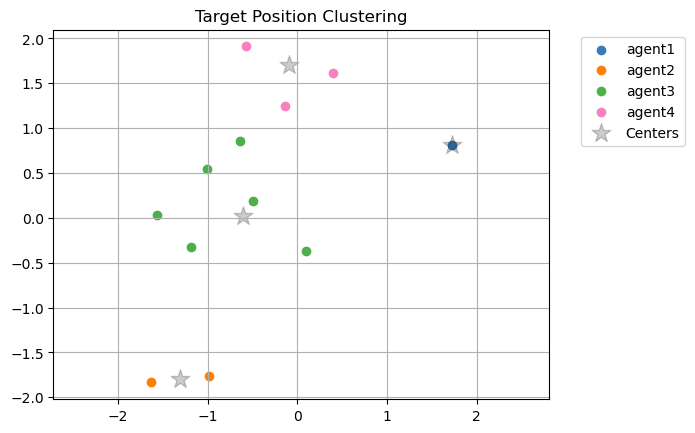

10
20
60
30


In [17]:
labels, centers, expended = kmeans_cost_division_clust(targets_pos, targets_cost)
clusters = zip_clusters(agents, targets, labels)
clusters_render(agents, clusters, centers)

# 분배된 코스트
for cluster in clusters:
    print(len(cluster)*10)

In [18]:
# tsp의 영역

In [19]:
def list_pos(agents_pos, clusters, finished_pos):
    agents_pos = agents_pos.tolist()
    finished_pos = finished_pos.tolist()
    
    clusters_pos = [[] for _ in range(len(agents_pos))]
    for i, targets in enumerate(clusters):
        for target in targets:
            x, y = target.state.pos.squeeze().tolist()
            clusters_pos[i].append([x, y])
    
    return agents_pos, clusters_pos, finished_pos

In [20]:
def numpy_pos_tcp(agents, clusters, finished_position):
    agents_pos = []
    for agent in agents:
        x, y = agent.state.pos.squeeze().tolist()
        agents_pos.append([x, y])
    agents_pos = np.array(agents_pos)

    targets_cost = []
    clusters_pos = [[] for _ in range(len(agents))]
    for i, cluster in enumerate(clusters):
        for target in cluster:
            x, y = target.state.pos.squeeze().tolist()
            clusters_pos[i].append([x, y])
            cost = target.cost.item()
            targets_cost.append(cost)
        
    clusters_pos = np.array(clusters_pos, dtype=object)
    targets_cost = np.array(targets_cost)

    finished_pos = []
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        finished_pos.append([x, y])
    finished_pos = np.array(finished_pos)
    
    return agents_pos, clusters_pos, targets_cost, finished_pos

In [21]:
agents_pos, clusters_pos, targets_cost, finished_pos = numpy_pos_tcp(agents, clusters, finished_position)
print(agents_pos)
print(clusters_pos)
print(targets_cost)
print(finished_pos)


[[ 0.91261506 -1.98939276]
 [ 0.75657058  0.19262552]
 [-0.04689121 -0.82199025]
 [ 0.95152092  0.42084694]]
[list([[1.7174346446990967, 0.8088462352752686]])
 list([[-0.984837532043457, -1.7649283409118652], [-1.6285326480865479, -1.8359382152557373]])
 list([[-1.5688300132751465, 0.027031421661376953], [-0.6371424198150635, 0.8532180786132812], [-1.0139427185058594, 0.5470032691955566], [-1.192276954650879, -0.32660508155822754], [-0.4993119239807129, 0.1907658576965332], [0.09662437438964844, -0.3751659393310547]])
 list([[-0.13901019096374512, 1.2520039081573486], [-0.5795810222625732, 1.9103169441223145], [0.3937821388244629, 1.6161916255950928]])]
[30 30 30 10 10 20 20 20 40 10 40 40]
[[ 0.2  0.2]
 [ 0.2 -0.2]
 [-0.2 -0.2]
 [-0.2  0.2]]


In [22]:
import itertools

def solve_open_tsp(points, start, finish):
    if not points:
        return (), np.linalg.norm(start - finish)
    
    best_cost = float('inf')
    best_perm = None
    for perm in itertools.permutations(range(len(points))):
        cost = np.linalg.norm(start - points[perm[0]])
        for i in range(len(perm)-1):
            cost += np.linalg.norm(points[perm[i]] - points[perm[i+1]])
        cost += np.linalg.norm(points[perm[-1]] - finish)
        if cost < best_cost:
            best_cost = cost
            best_perm = perm
    return best_perm, best_cost

def open_tsp_assignment(agents, clusters, finished_targets):
    agents_pos, clusters_pos, targets_cost, finished_pos = numpy_pos_tcp(agents, clusters, finished_position)
    n_agents = len(agents)
    best_total_cost = float('inf')
    best_assignment = None
    best_routes = {}  # 임시 저장: {agent_idx: {'cluster_index': ..., 'route_order': ..., 'cost': ..., 'cluster_targets': ...}}
    
    # 모든 할당(에이전트와 클러스터의 순열)을 고려 (총 4! 가지)
    for perm in itertools.permutations(range(n_agents)):
        total_cost = 0.0
        routes = {}
        for agent_idx, cluster_idx in enumerate(perm):
            start = agents_pos[agent_idx]
            finish = finished_pos[agent_idx]
            
            # 할당된 클러스터 내의 타겟들의 좌표 추출
            cluster = clusters[cluster_idx]
            points = [target for target in cluster]
            
            # open TSP 해결: start → cluster의 타겟 순회 → finish
            route_order, cost = solve_open_tsp(points, start, finish)
            total_cost += cost
            routes[agent_idx] = {
                'cluster_index': cluster_idx,
                'route_order': route_order,   # cluster 리스트 내에서의 순서 (인덱스 튜플)
                'cost': cost,
                'cluster_targets': cluster
            }
        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_assignment = perm
            best_routes = routes
    
    # best_routes 딕셔너리를 이용해 2차원 리스트 형태로 각 에이전트별 방문 타겟 객체들을 재배열
    best_routes_2d = []
    for agent_idx in range(n_agents):
        route_info = best_routes[agent_idx]
        cluster_targets = route_info['cluster_targets']
        # route_order는 cluster_targets 내 인덱스 순서
        ordered_targets = [cluster_targets[i] for i in route_info['route_order']]
        best_routes_2d.append(ordered_targets)
    
    return best_routes_2d, best_total_cost

In [23]:
best_routes_2d, best_total_cost = open_tsp_assignment(agents=agents, clusters=clusters, finished_targets=finished_pos)

TypeError: unsupported operand type(s) for -: 'float' and 'Landmark'

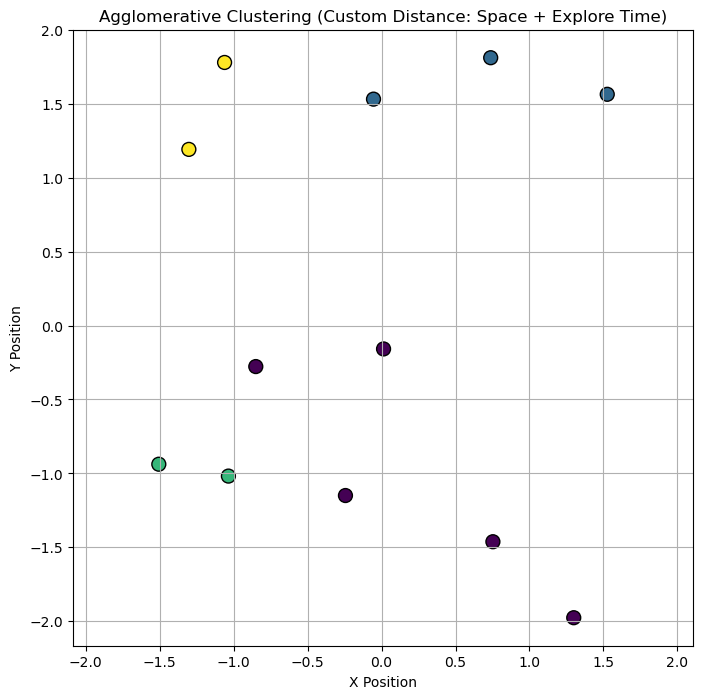

클러스터 라벨: [1 0 0 1 3 0 3 1 0 0 2 2]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

# 예시용 더미 데이터 (실제 상황에 맞게 targets_pos, targets_cost 정의하세요)
# targets_pos: (N, 2) 배열
# targets_cost: (N,) 배열

# (pos + cost)를 합쳐서 (x, y, t) 형태로 만들기
features = np.column_stack((targets_pos, targets_cost))

# 📌 사용자 정의 거리 함수
def custom_distance(v1, v2):
    x1, y1, t1 = v1
    x2, y2, t2 = v2
    space_dist = np.linalg.norm([x1 - x2, y1 - y2])
    time_weight = 0.04
    return space_dist + time_weight * (t1 + t2)

# 거리 행렬 계산
distance_matrix = squareform(pdist(features, metric=custom_distance))

# 📌 Agglomerative Clustering 실행
clustering = AgglomerativeClustering(n_clusters=4, metric='precomputed', linkage='complete')
labels = clustering.fit_predict(distance_matrix)

# 클러스터별 target 묶기 (targets가 있다면 여기서 매핑)
clusters = [[] for _ in range(4)]
for i, label in enumerate(labels):
    clusters[label].append(targets_pos[i])

# 📊 시각화
plt.figure(figsize=(8, 8))
plt.scatter(targets_pos[:, 0], targets_pos[:, 1], c=labels, cmap='viridis', s=100, edgecolors='k')
plt.title("Agglomerative Clustering (Custom Distance: Space + Explore Time)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.show()

# 클러스터 결과 확인
print("클러스터 라벨:", labels)
